In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

# ML libraries
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import math
import datetime as dtm

In [2]:
# LOAD DATA
df = pd.read_csv("SCOM08.csv", skipinitialspace=True)

# CLEANING DATA
# Reverse dataframe starting with earliest stock as first index
df = df.iloc[::-1]
# Drop reversed index and add default integer index
df = df.reset_index()
df = df.drop('index', axis=1)

# Convert date column to standard date format
for idx, row in df.iterrows():
    row.Date = dtm.datetime.strptime(row.Date, "%m/%d/%y")
    # row.Date = row.Date.strftime("%Y-%m-%d")
    df.at[idx,"Date"] = row.Date

# Get start date and end date
start = df['Date'].iloc[0].strftime("%Y-%m-%d")
end = df['Date'].iloc[len(df) - 1].strftime("%Y-%m-%d")

# Set Date as default index
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Volume
Date,,,,,
2008-06-09,7.35,7.35,7.35,7.35,416383094
2008-06-10,6.95,6.95,6.95,6.95,127305797
2008-06-11,7.00,7.00,7.00,7.00,183494797
2008-06-12,7.35,7.35,7.35,7.35,131243703
2008-06-13,7.35,7.45,7.45,7.45,250901500
...,...,...,...,...,...
2023-07-03,17.60,18.00,17.60,17.75,467500
2023-07-04,18.00,18.00,17.60,17.80,15905700
2023-07-05,17.90,17.90,17.60,17.70,2346400


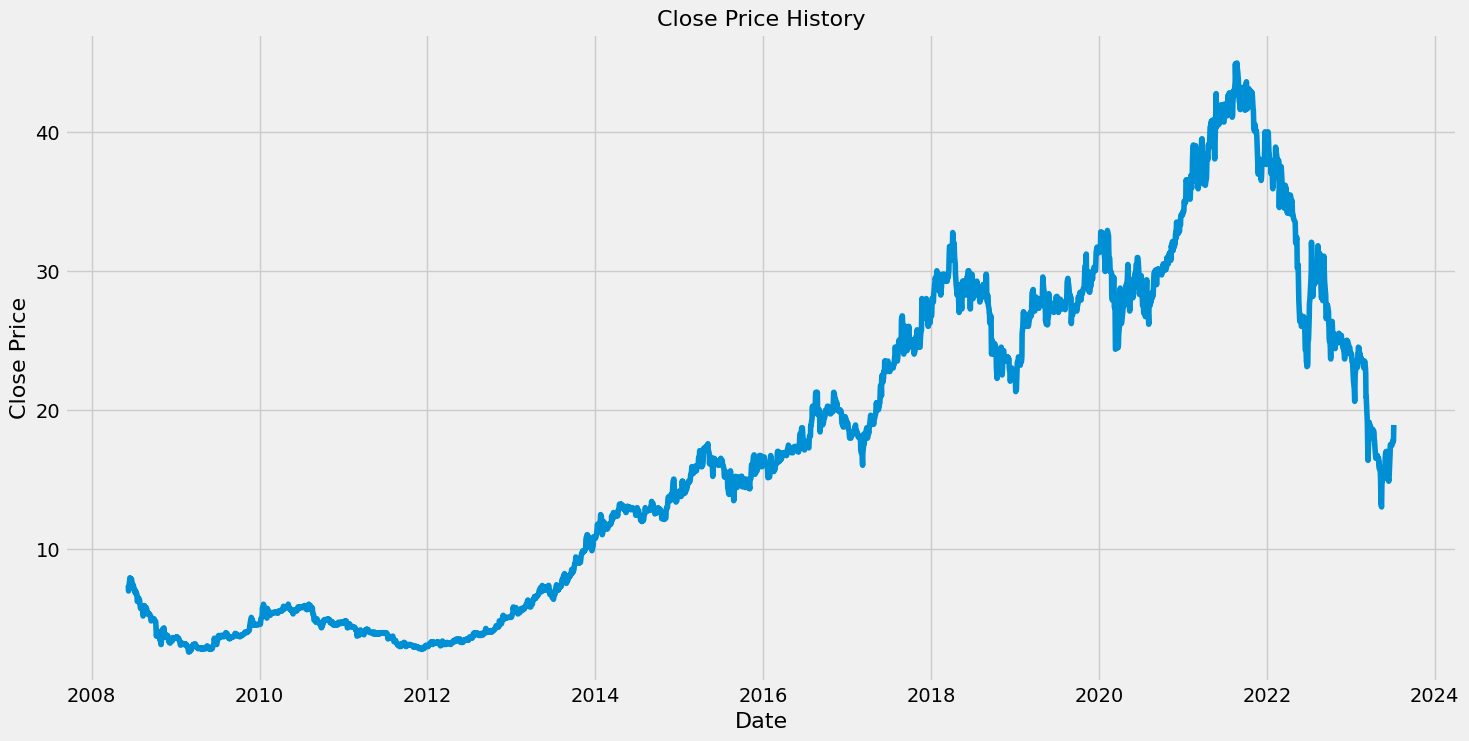

In [3]:
# Plot historical closing price
plt.figure(figsize=(16,8))
plt.title("Close Price History", fontsize=16)
plt.plot(df.Close)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close Price", fontsize=16)
plt.show()

In [4]:
# New dataframe with only close column
data = df.filter(["Close"])
data

,Close
Date,
2008-06-09,7.35
2008-06-10,6.95
2008-06-11,7.00
2008-06-12,7.35
2008-06-13,7.45
...,...
2023-07-03,17.75
2023-07-04,17.80
2023-07-05,17.70


In [5]:
# Convert the dataframe into a numpy array
dataset = data.values

In [6]:
# Get length of training and testing data
training_data_len = math.ceil(len(dataset) * 0.8)
test_data_len = len(dataset) - training_data_len
print("Training data length")
print(training_data_len)
print("Testing data length")
print(test_data_len)

Training data length
3019
Testing data length
754


In [7]:
# Scale down data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.11320755],
       [0.10377358],
       [0.10495283],
       ...,
       [0.35731132],
       [0.36084906],
       [0.38561321]])

In [8]:
# Split dataset into xtrain and ytrain
train_data = scaled_data[0: training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)): 
    x_train.append(train_data[i-60: i, 0])
    y_train.append(train_data[i, 0])

In [9]:
# Convert xtrain and ytrain to numpy arrays for lstm model
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
# Reshape to 3D, the required format for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2959, 60, 1)

In [11]:
# LSTM Model
model = Sequential()

# First layer
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# Second layer
model.add(LSTM(50, return_sequences=False))
# Third layer
model.add(Dense(25))
# Fourth layer
model.add(Dense(1))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# Compile model
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(x_train, y_train, batch_size=1, epochs=1)

2959/2959 [==============================] - 24s 8ms/step - loss: 9.5454e-04


In [14]:
model.save("new_ke_lstm_model")

INFO:tensorflow:Assets written to: ke_lstm_model3/assets


INFO:tensorflow:Assets written to: ke_lstm_model3/assets


In [15]:
# Testing dataset
test_data = scaled_data[training_data_len - 60: , :]

x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60: i, 0])

# Convert to numpy arrays
x_test = np.array(x_test)

In [16]:
# Reshape to 3D format
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(754, 60, 1)

In [18]:
# Get the models predicted values
predictions = model.predict(x_test)
# Scale down data
predictions = scaler.inverse_transform(predictions)

24/24 [==============================] - 0s 5ms/step


In [19]:
# Evaluate Model
# Get RMSE - root mean square error
# The closer the number to zero, the closer the predicted values to original values,
#  the better it was predicting 
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.12611332243254084

/var/folders/4f/xy4jvtjs1qg16v7xbbpgsc840000gn/T/ipykernel_61191/1099830945.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


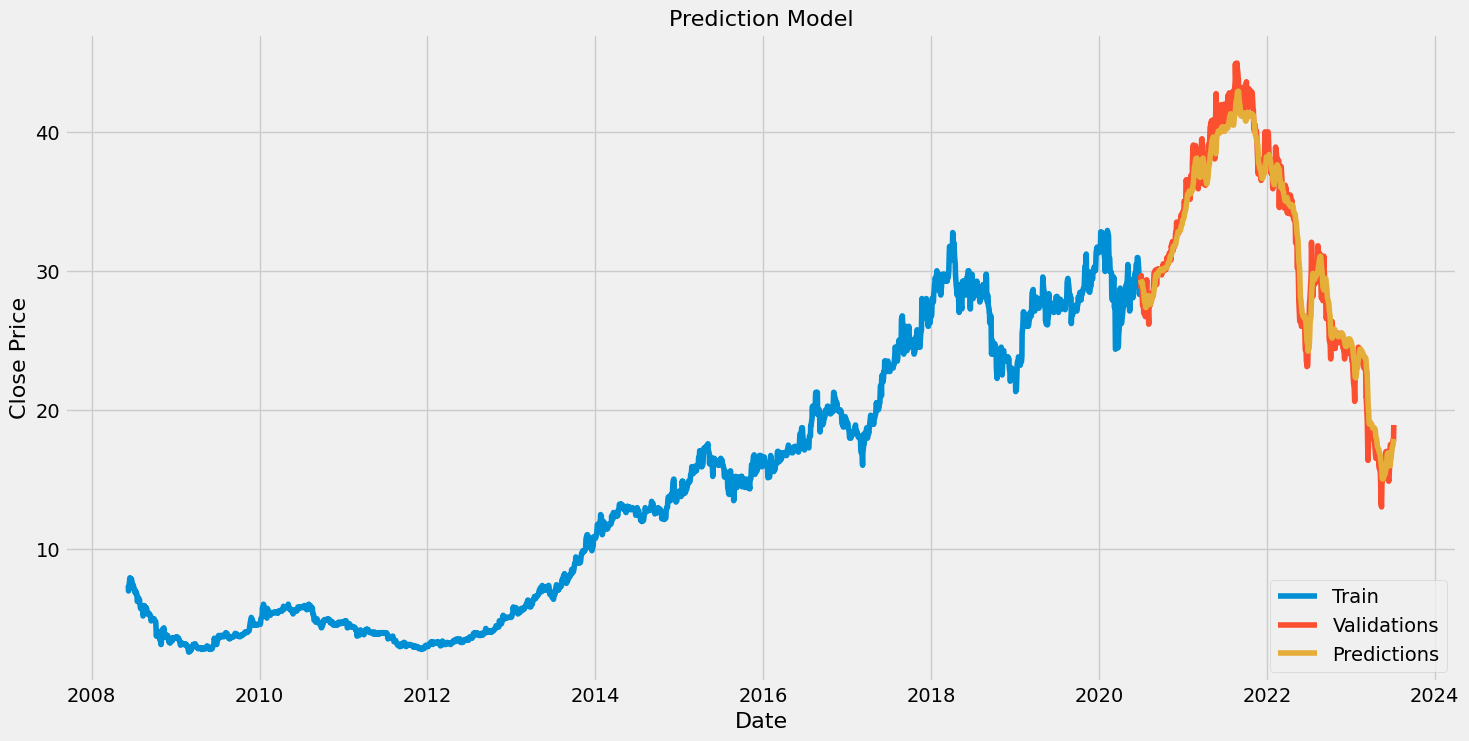

In [20]:
# Plot data
train = data[0: training_data_len] # from zero
valid = data[training_data_len:] # validation data
valid["Predictions"] = predictions

# Visualise data
plt.figure(figsize=(16,8))
plt.title("Prediction Model", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close Price", fontsize=16)
plt.plot(train.Close)
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Validations", "Predictions"], loc="lower right")
plt.show()

In [21]:
# Show valid and predicted
valid

,Close,Predictions
Date,,
2020-07-01,28.70,29.355272
2020-07-02,29.00,29.215786
2020-07-03,29.65,29.141935
2020-07-06,29.10,29.172043
2020-07-07,28.10,29.197927
...,...,...
2023-07-03,17.75,17.413042
2023-07-04,17.80,17.561790
2023-07-05,17.70,17.696442


In [22]:
# Predict for the next n_days => n_days can be 10, 20, 30, 60, 100 days e.t.c
n_days = 30
# Create new dataframe
new_df = df.filter(["Close"])

# Combined dataframe: Contains original close prices and predicted prices
combined = new_df

data = {
    "Date": [],
    "Close": []
}
next_n_days = pd.DataFrame(data)
next_n_days.set_index('Date', inplace=True)

last_day = dtm.datetime.strptime(end, "%Y-%m-%d")
# last_day = last_day - dtm.timedelta(days=1)
last_day = last_day.strftime("%Y-%m-%d")
last_day = dtm.datetime.strptime(last_day, "%Y-%m-%d")

for i in range(n_days):
    # Get the last 100 days closing price and convert dataframe to an array
    last_n_days = combined[-100:].values
    # Scale down data
    last_n_days_scaled = scaler.transform(last_n_days)
    X_test = []
    X_test.append(last_n_days_scaled)
    # Convert to numpy arrays
    X_test = np.array(X_test)
    # Reshape to 3D format
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    # Predicted price
    pred_price = model.predict(X_test)
    # Scale up
    pred_price = scaler.inverse_transform(pred_price)
    
    #. Update dataframe with predicted value
    tomorrow = last_day + dtm.timedelta(days=1)
    # tomorrow = tomorrow.strftime("%Y-%m-%d")
    new_row = {
        "Date": [tomorrow],
        "Close": [pred_price[0].tolist()[0]]
    }
    last_day = tomorrow
    # last_day = dtm.datetime.strptime(last_day, "%Y-%m-%d")
    
    next_day = pd.DataFrame(new_row)
    next_day.set_index('Date', inplace=True)
    next_n_days = pd.concat([next_n_days, next_day])
    combined = pd.concat([combined, next_day])

1/1 [==============================] - 0s 11ms/step


In [23]:
new_df

,Close
Date,
2008-06-09,7.35
2008-06-10,6.95
2008-06-11,7.00
2008-06-12,7.35
2008-06-13,7.45
...,...
2023-07-03,17.75
2023-07-04,17.80
2023-07-05,17.70


In [24]:
next_n_days

,Close
Date,
2023-07-08,18.074072
2023-07-09,18.202240
2023-07-10,18.304850
2023-07-11,18.393694
2023-07-12,18.475283
2023-07-13,18.553171
2023-07-14,18.629280
2023-07-15,18.704626
2023-07-16,18.779749


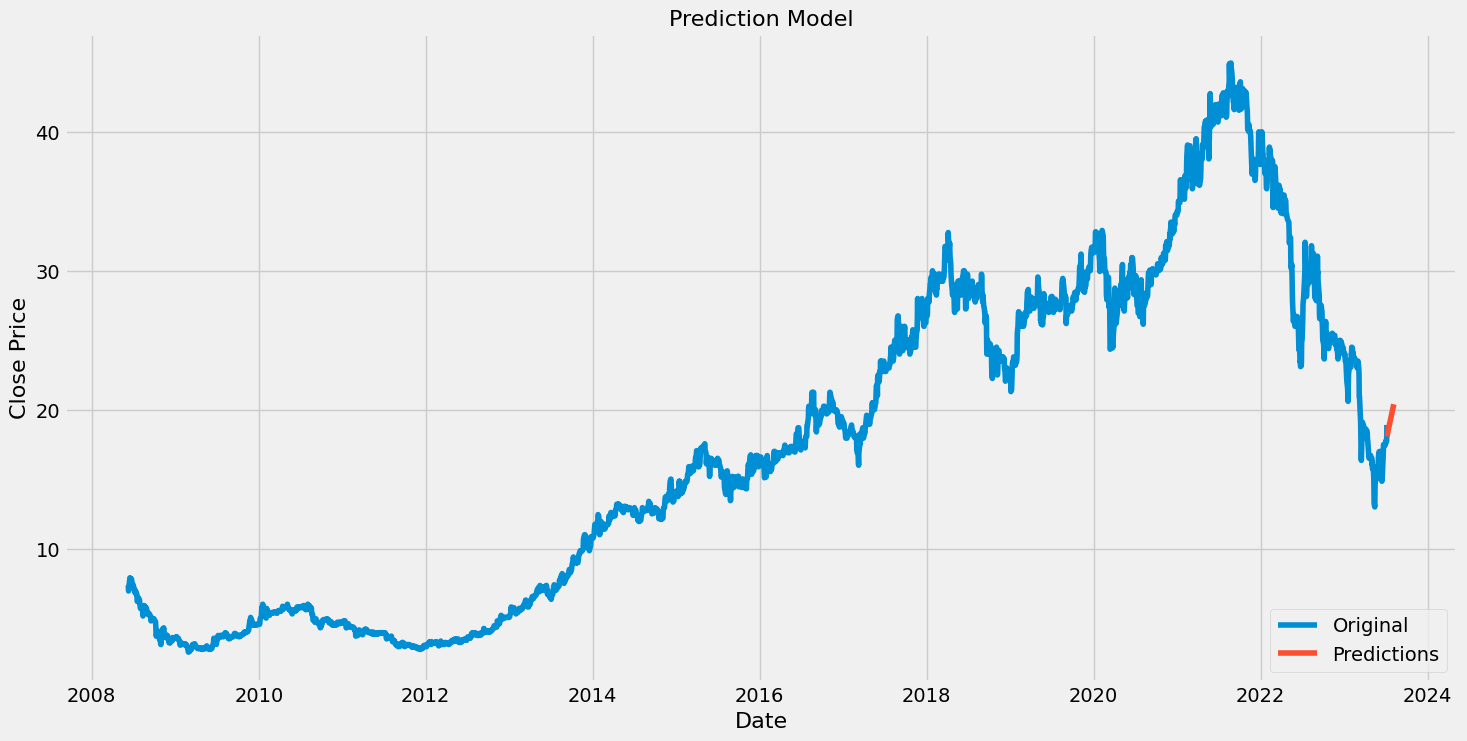

In [25]:
# Visualise data
plt.figure(figsize=(16,8))
plt.title("Prediction Model", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close Price", fontsize=16)
plt.plot(new_df.Close)
plt.plot(next_n_days.Close)
plt.legend(["Original", "Predictions"], loc="lower right")
plt.show()